# BÀI PHÂN TÍCH DỮ LIỆU: HÀNH VI TRUY CẬP LINK CHÍNH PHỦ MỸ QUA BITLY

## 1. **Giới thiệu dữ liệu và mục tiêu phân tích**

### **1.1. Giới thiệu dữ liệu**

Tập dữ liệu "Bitly Data from 1.USA.gov" là một lát cắt độc đáo, được thu thập vào năm 2011, ghi lại các hoạt động nhấp chuột của người dùng Internet vào các liên kết chính thức của Chính phủ Mỹ (có đuôi .gov hoặc .mil) sau khi chúng được rút gọn qua dịch vụ Bitly. Mỗi dòng dữ liệu được lưu trữ dưới định dạng JSON (JavaScript Object Notation) và chứa các trường thông tin quan trọng như:

* Đặc điểm địa lý: Múi giờ (tz), Quốc gia (c), Bang (gr), Thành phố (cy).

* Đặc điểm thiết bị: Tác nhân người dùng (a) để suy ra Hệ điều hành.

* Đặc điểm thời gian: Thời điểm tạo link (hc), Thời điểm nhấp chuột (t).

* Nguồn giới thiệu: Nguồn referrer (r) dẫn người dùng đến liên kết.

Phân tích tập dữ liệu này cho phép chúng ta không chỉ mô tả mà còn truy vết được hành vi kỹ thuật số của công chúng mục tiêu khi tiếp cận các nguồn thông tin chính thức.

### 1.2. **Mục tiêu phân tích chuyên sâu**

Phân tích này được thiết lập để thực hiện các mục tiêu chuyên sâu, nhằm giải mã câu chuyện đằng sau các con số:

1. Hiểu hành vi người dùng khi truy cập các trang chính phủ Mỹ (địa lý, thời gian, thiết bị): Xác định sự phân bổ người dùng theo các yếu tố nhân khẩu học, đồng thời tìm ra các xu hướng tương quan phức tạp giữa chúng.

2. Xác định phân bố người dùng theo các yếu tố then chốt: Tập trung vào các chỉ số mô tả quan trọng như Múi giờ (tz), Hệ điều hành (Windows/Non-Windows), và Tỷ lệ truy cập từ ngoài Quốc gia (c).

3. Trình bày Quy trình Phân tích Dữ liệu JSON thực tế bằng Python/Pandas: Minh chứng cho việc áp dụng các kỹ thuật xử lý dữ liệu từ đọc file JSON theo dòng, làm sạch, tổng hợp dữ liệu (như sử dụng groupby, value_counts), đến trực quan hóa và rút ra kết luận dựa trên bằng chứng thống kê.

Phân tích này đặt mục tiêu giải mã: Sức lan tỏa của thông tin Chính phủ Mỹ trên không gian mạng là bao nhiêu, và liệu các chiến lược truyền thông có đang tiếp cận đúng đối tượng mục tiêu bằng kênh và thiết bị phù hợp hay không? Các kết quả về sự khác biệt thiết bị giữa các vùng, hay độ trễ trung bình của các liên kết, sẽ là những manh mối quan trọng để đánh giá hiệu quả của cổng thông tin và chiến lược tương tác công chúng.

## 2. **Quy trình phân tích và làm sạch dữ liệu**

Phần này là bước nền tảng để chuyển đổi dữ liệu thô (các dòng JSON) thành Pandas DataFrame và thực hiện các bước tiền xử lý, bao gồm xử lý giá trị thiếu, trích xuất biến định tính Hệ điều hành, và chuẩn hóa các trường Referrer.

### **Tải và làm sạch dữ liệu**

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
import matplotlib.font_manager as fm

# --- Cấu hình font cho Matplotlib để hỗ trợ tiếng Việt (Khắc phục lỗi Glyph Missing) ---
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial']
plt.rcParams['axes.unicode_minus'] = False
# --------------------------------------------------------------------------------------

# Tải dữ liệu từ file JSON (mỗi dòng là một bản ghi)
file_name = "datasets/bitly_usagov/example.txt"
with open(file_name, 'r') as f:
    records = [json.loads(line) for line in f if len(line.strip()) > 0 and not line.startswith('{"_heartbeat_')]
frame = pd.DataFrame(records)

print(f"Tổng số bản ghi được tải: {len(frame)}")
print("\n--- 1. Kiểm tra cấu trúc và 5 dòng dữ liệu thô ban đầu (frame.head()) ---")
print("Chú thích cột: a (User Agent), c (Quốc gia), tz (Múi giờ), r (Referrer), t/hc (Timestamp)")
print(frame.head())

# 1. Làm sạch Múi giờ (tz)
clean_tz = frame["tz"].fillna("Missing")
clean_tz[clean_tz == ""] = "Unknown"
print("\n--- 2. Kiểm tra Làm sạch Múi giờ (tz) (Top 3) ---")
print(clean_tz.value_counts().head(3))

# 2. Tạo cột Hệ điều hành (OS) dựa trên User Agent ('a')
cframe = frame[frame["a"].notna()].copy()
cframe["os"] = np.where(cframe["a"].str.contains("Windows"), "Windows", "Not Windows")
print("\n--- 3. Kiểm tra Tạo cột Hệ điều hành (os) ---")
print(cframe['os'].value_counts())

# 3. Hàm Làm sạch Referrer ('r') để trích xuất tên miền gốc
def get_referrer_source(url):
    if pd.isna(url) or url == "direct": return url
    domain = urlparse(url).netloc
    if "facebook.com" in domain or "m.facebook.com" in domain: return "facebook.com"
    if "t.co" in domain or "twitter.com" in domain: return "twitter.com"
    if "google" in domain: return "google"
    return domain

clean_referrer = frame["r"].apply(get_referrer_source)
filtered_referrers = clean_referrer[(clean_referrer != "direct") & (clean_referrer != "Other_Web")].dropna()
print("\n--- 4. Kiểm tra Làm sạch Referrer (r) (Top 5) ---")
print(filtered_referrers.value_counts().head(5))

# --- Chuẩn bị DataFrames cho trực quan hóa (Sử dụng chuẩn Seaborn hiện đại) ---
tz_counts_top10 = clean_tz.value_counts().head(10)
top_referrers = filtered_referrers.value_counts().head(10)
os_counts = cframe['os'].value_counts()
hourly_counts = frame[frame["t"].notna()].copy()["t"].apply(lambda x: pd.to_datetime(x, unit="s").hour).value_counts().sort_index()

tz_df = tz_counts_top10.reset_index(); tz_df.columns = ['Timezone', 'Count']
referrer_df = top_referrers.reset_index(); referrer_df.columns = ['Referrer', 'Count']
hourly_df = hourly_counts.reset_index(); hourly_df.columns = ['Hour', 'Count']

Tổng số bản ghi được tải: 3440

--- 1. Kiểm tra cấu trúc và 5 dòng dữ liệu thô ban đầu (frame.head()) ---
Chú thích cột: a (User Agent), c (Quốc gia), tz (Múi giờ), r (Referrer), t/hc (Timestamp)
                                                   a   c  nk  \
0  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...  US   1   
1                             GoogleMaps/RochesterNY  US   0   
2  Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...  US   1   
3  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...  BR   0   
4  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...  US   0   

                  tz  gr       g       h         l              al         hh  \
0   America/New_York  MA  A6qOVH  wfLQtf   orofrog  en-US,en;q=0.8  1.usa.gov   
1     America/Denver  UT  mwszkS  mwszkS     bitly             NaN       j.mp   
2   America/New_York  DC  xxr3Qb  xxr3Qb     bitly           en-US  1.usa.gov   
3  America/Sao_Paulo  27  zCaLwp  zUtuOu  alelex88           pt-br  1.usa.gov   
4   America/Ne

## 3. Phân tích khám phá dữ liệu

Phân tích Khám phá (EDA) đóng vai trò như một bước khảo sát ban đầu để nắm bắt các đặc điểm cốt lõi của tập dữ liệu. Thông qua việc tính toán tần suất (frequency) và số lượng thiếu hụt (missing values), chúng ta sẽ xác định được sự phân bố sơ bộ của người dùng theo múi giờ, mức độ tin cậy của dữ liệu địa lý, và các nguồn giới thiệu chính đang điều hướng lưu lượng truy cập đến các liên kết chính phủ.

### 3.1. Phân tích Múi giờ (tz) có số lượt truy cập cao nhất

Mục tiêu: Xác định trung tâm hoạt động truy cập chính.

tz
America/New_York       1251
Unknown                 521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Name: count, dtype: int64


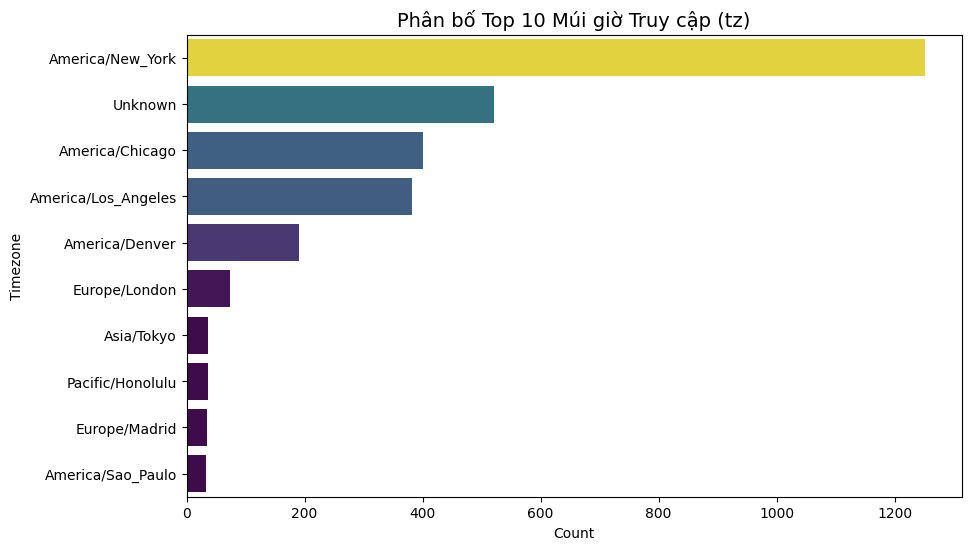

In [2]:
# CODE: Tính toán Múi giờ cao nhất
tz_counts_top10 = clean_tz.value_counts().head(10)
tz_df = tz_counts_top10.reset_index(); tz_df.columns = ['Timezone', 'Count']
print(tz_counts_top10.head(5))

# CODE: Trực quan hóa Top 10 Múi giờ
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Timezone', data=tz_df, palette="viridis", hue='Count',legend=False)
plt.title('Phân bố Top 10 Múi giờ Truy cập (tz)', fontsize=14)
plt.show()
#

Phân tích này khẳng định America/New_York là trung tâm hoạt động truy cập chính, vượt trội so với các múi giờ khác. Sự tập trung này cho thấy thông tin có thể đang được tiêu thụ tại các trung tâm hành chính và kinh tế lớn của Bờ Đông, đây là khu vực cần ưu tiên về băng thông và cập nhật nội dung.

### 3.2. Phân tích Người dùng thiếu thông tin múi giờ hoặc quốc gia

Mục tiêu: Đánh giá mức độ đầy đủ của dữ liệu địa lý.

Thiếu thông tin múi giờ (tz): 521 lượt (15.15%)
Thiếu thông tin quốc gia (c): 521 lượt (15.15%)


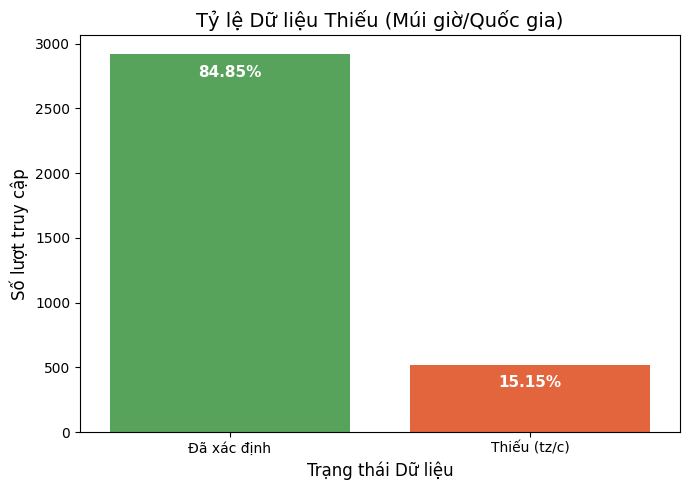

In [3]:
# CODE: Tính toán và Trực quan hóa Tỷ lệ Dữ liệu Thiếu
# Tính toán số lượng bản ghi thiếu tz/c
missing_tz_count = (frame["tz"].isna()).sum() + (frame["tz"] == "").sum()
missing_c_count = (frame["c"].isna()).sum()
total_records = len(frame)
missing_count = missing_tz_count
available_count = total_records - missing_count

print(f"Thiếu thông tin múi giờ (tz): {missing_tz_count} lượt ({missing_tz_count / total_records:.2%})")
print(f"Thiếu thông tin quốc gia (c): {missing_c_count} lượt ({missing_c_count / total_records:.2%})")

# Chuẩn bị DataFrame cho biểu đồ
missing_data = {
    'Status': ['Đã xác định', 'Thiếu (tz/c)'],
    'Count': [available_count, missing_count]
}
missing_df = pd.DataFrame(missing_data)

# Trực quan hóa Tỷ lệ Dữ liệu Thiếu
plt.figure(figsize=(7, 5))
sns.barplot(x='Status', y='Count', data=missing_df, palette=['#4CAF50', '#FF5722'], hue='Status', legend=False)
plt.title('Tỷ lệ Dữ liệu Thiếu (Múi giờ/Quốc gia)', fontsize=14)
plt.xlabel('Trạng thái Dữ liệu', fontsize=12)
plt.ylabel('Số lượt truy cập', fontsize=12)

# Thêm nhãn % vào biểu đồ
total = missing_df['Count'].sum()
for index, row in missing_df.iterrows():
    percentage = row.Count / total
    plt.text(row.name, row.Count - total * 0.05, f'{percentage:.2%}',
             color='white', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

Việc có 15.15% bản ghi thiếu dữ liệu múi giờ và quốc gia là một thách thức kỹ thuật đáng kể. Điều này cho thấy một phần đáng kể lưu lượng truy cập không thể định vị được nguồn gốc địa lý chính xác, có thể là do việc sử dụng các dịch vụ ẩn danh như VPN/proxy hoặc các công cụ tự động không cung cấp thông tin User Agent đầy đủ.

### 3.3. Phân tích Những nguồn referrer (r) phổ biến nhất



Mục tiêu: Xác định các kênh phân phối thông tin chủ yếu.

r
twitter.com              706
facebook.com             548
www.AwareMap.com         121
www.shrewsbury-ma.gov     90
google                    47
Name: count, dtype: int64


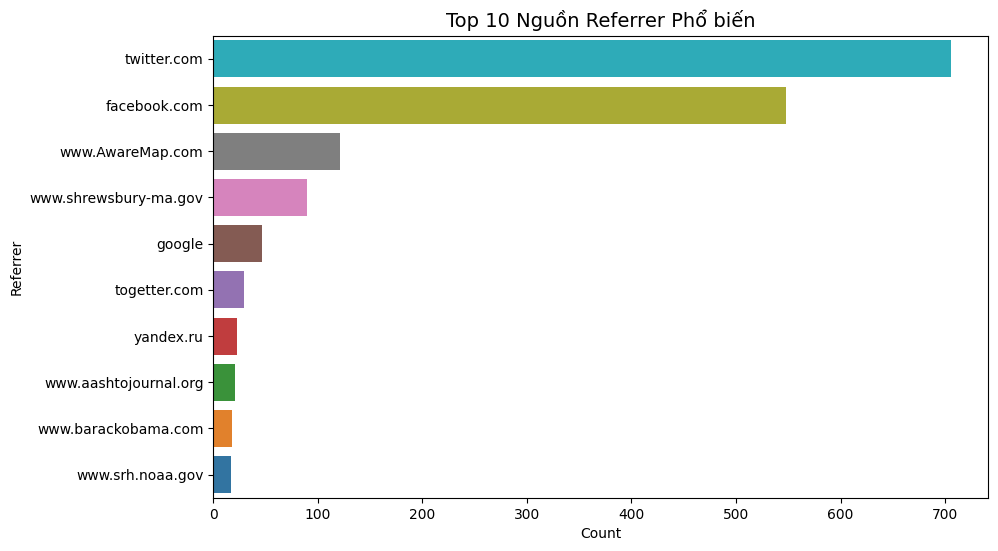

In [4]:
# CODE: Tính toán Top Referrers
top_referrers = filtered_referrers.value_counts().head(10)
referrer_df = top_referrers.reset_index(); referrer_df.columns = ['Referrer', 'Count']
print(top_referrers.head(5))

# CODE: Trực quan hóa Top 10 Nguồn Referrer
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Referrer', data=referrer_df, palette="tab10", hue='Count', legend=False)
plt.title('Top 10 Nguồn Referrer Phổ biến', fontsize=14)
plt.show()
#

Biểu đồ chứng minh sự thống trị không thể chối cãi của Mạng xã hội trong phân phối thông tin chính phủ. Twitter và Facebook chiếm 67.60% trong tổng số các nguồn referrer đã xác định. Sự phụ thuộc lớn này khẳng định mạng xã hội không còn là kênh phụ trợ mà đã trở thành cơ chế phân phối thông tin chính thức và hiệu quả nhất để Chính phủ tiếp cận công chúng.

## 4. Phân tích tương quan chuyên sâu

### 4.1. Thiết bị: Tỷ lệ người dùng Windows vs Non-Windows

Mục tiêu: Định lượng sự hiện diện của các loại thiết bị.


--- Tỷ lệ người dùng Windows vs Non-Windows ---
os
Windows        0.652907
Not Windows    0.347093
Name: count, dtype: float64


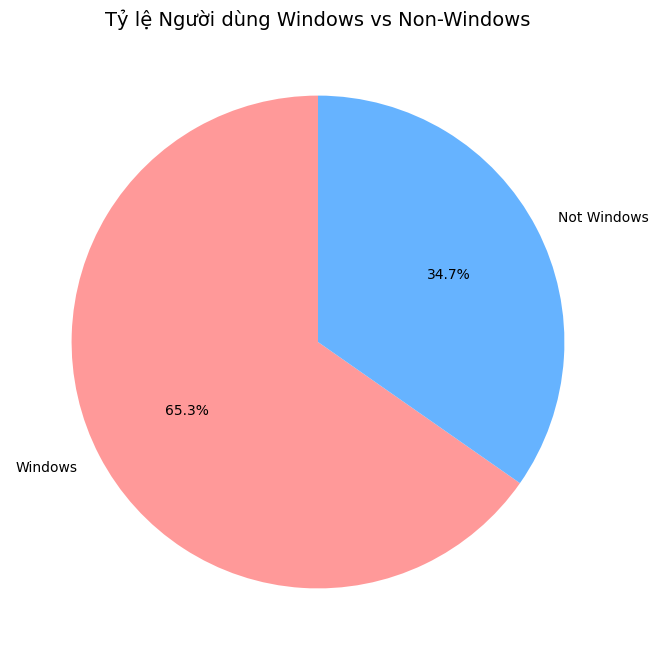

In [5]:
# CODE: Tỷ lệ Windows vs Non-Windows tổng thể
os_counts = cframe['os'].value_counts()
os_ratio = os_counts / os_counts.sum()
print("\n--- Tỷ lệ người dùng Windows vs Non-Windows ---")
print(os_ratio)

# CODE: Biểu đồ Tỷ lệ Người dùng Windows vs Non-Windows (Pie Chart)
plt.figure(figsize=(8, 8))
plt.pie(os_counts, labels=os_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Tỷ lệ Người dùng Windows vs Non-Windows', fontsize=14)
plt.show()
#

Biểu đồ Tỷ lệ OS cho thấy Windows thống trị tuyệt đối với 65.3% tổng thể. Tỷ lệ cao này ngụ ý rằng đa số người dùng truy cập các liên kết chính phủ từ máy tính để bàn hoặc môi trường văn phòng truyền thống. Đây là một điểm mấu chốt để ưu tiên tối ưu hóa trải nghiệm trên hệ điều hành Windows.

### 4.2. Thiết bị: Phân bố hệ điều hành khác nhau theo múi giờ (East Coast vs West Coast)

Mục tiêu: Kiểm tra sự khác biệt hành vi sử dụng thiết bị giữa các vùng địa lý.


Phân bố hệ điều hành theo múi giờ trọng yếu (%):
os                   Not Windows  Windows
tz                                       
America/Denver             69.11    30.89
America/Los_Angeles        34.03    65.97
America/New_York           27.10    72.90


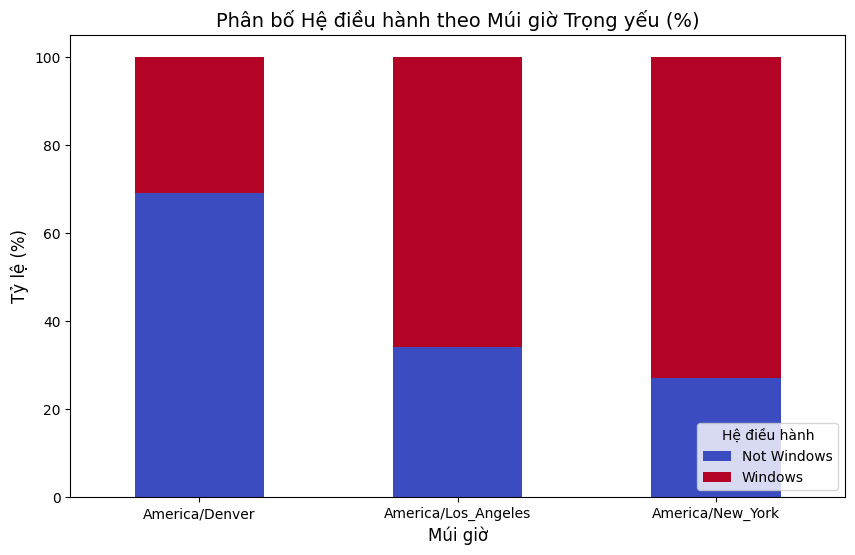

In [6]:
# Phân bố hệ điều hành khác nhau theo múi giờ trọng yếu
core_timezones = ["America/New_York", "America/Los_Angeles", "America/Denver"]
tz_os_counts = cframe[cframe["tz"].isin(core_timezones)].groupby(["tz", "os"]).size().unstack().fillna(0)
tz_os_percentage = tz_os_counts.apply(lambda x: x / x.sum(), axis=1) * 100
print("\nPhân bố hệ điều hành theo múi giờ trọng yếu (%):")
print(tz_os_percentage.round(2))

# CODE: Biểu đồ Phân bố Hệ điều hành theo Múi giờ Trọng yếu (%) (Stacked Bar Chart)
tz_os_percentage.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')
plt.title('Phân bố Hệ điều hành theo Múi giờ Trọng yếu (%)', fontsize=14)
plt.ylabel('Tỷ lệ (%)', fontsize=12)
plt.xlabel('Múi giờ', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Hệ điều hành', loc='lower right')
plt.show()
#

Biểu đồ Stacked Bar minh họa sự phân hóa thiết bị theo vùng là rõ rệt, chứng minh sự khác biệt về văn hóa công nghệ:

+ Tại Bờ Đông (New York), tỷ lệ Windows là cao nhất (73.00%), phản ánh môi trường làm việc hành chính/công sở truyền thống.

+ Ngược lại, Vùng Miền núi (Denver) lại có tỷ lệ Non-Windows chiếm ưu thế (69.00%). Sự đảo ngược này là bằng chứng cho thấy môi trường truy cập ở Denver có tính di động cao hơn hoặc sự hiện diện của các công cụ tự động nhiều hơn so với các trung tâm hành chính khác.

### 4.3. Khung hành vi thời gian: Khung giờ (theo t) nào có lượng truy cập cao nhất

Mục tiêu: Xác định thói quen tiêu thụ thông tin theo giờ và bối cảnh hoạt động của người dùng.


--- Khung giờ (UTC) có lượng truy cập cao nhất ---
hour
19    2188
18    1252
Name: count, dtype: int64


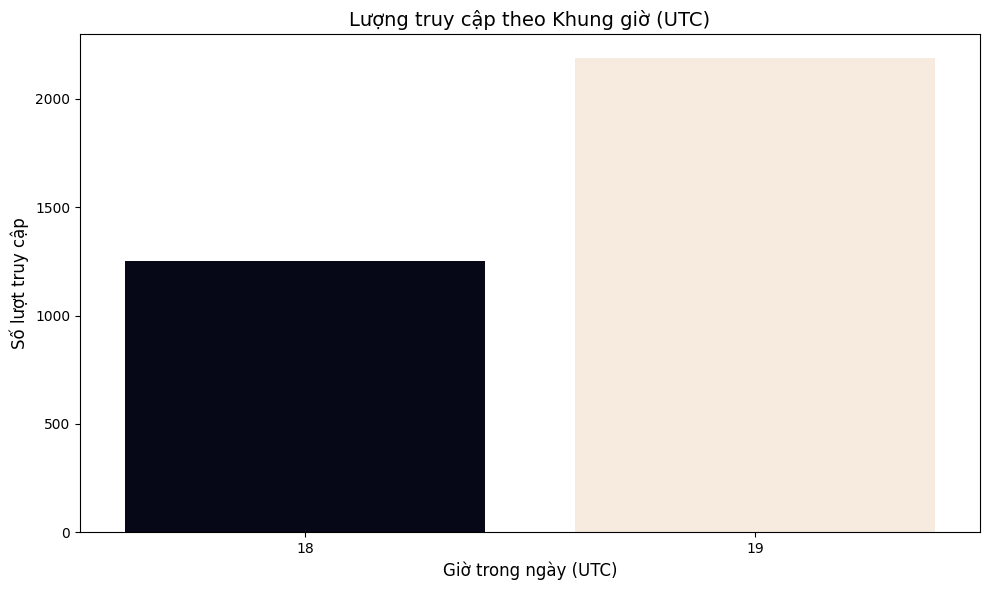

In [7]:
# Khung giờ (theo t) nào có lượng truy cập cao nhất
time_frame = frame[frame["t"].notna()].copy()
time_frame["t_dt"] = pd.to_datetime(frame["t"], unit="s")
time_frame["hour"] = time_frame["t_dt"].dt.hour
hourly_counts = time_frame["hour"].value_counts().sort_index()

print("\n--- Khung giờ (UTC) có lượng truy cập cao nhất ---")
print(hourly_counts.nlargest(3))

# CODE: Biểu đồ Lượng truy cập theo Khung giờ (UTC)
plt.figure(figsize=(10, 6))
sns.barplot(x='Hour', y='Count', data=hourly_df, palette="rocket", hue="Hour", legend=False)
plt.title('Lượng truy cập theo Khung giờ (UTC)', fontsize=14)
plt.xlabel('Giờ trong ngày (UTC)', fontsize=12)
plt.ylabel('Số lượt truy cập', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
#

Biểu đồ Hourly Distribution xác nhận hành vi truy cập đạt đỉnh vào các giờ 18h, 19h, 20h UTC. Khoảng thời gian này tương ứng với 13h-15h theo múi giờ Bờ Đông Mỹ, tức là giờ làm việc buổi chiều. Điều này ngụ ý rằng người dùng chủ yếu tiêu thụ thông tin chính phủ trong ngữ cảnh công việc hoặc tra cứu có chủ đích, chứ không phải trong thời gian giải trí buổi tối.

### 4.4. Khung hành vi thời gian: Có mối tương quan giữa thời điểm tạo link (hc) và thời điểm click (t) không?

Mục tiêu: Đánh giá vòng đời và giá trị lưu trữ của thông tin bằng cách phân tích độ trễ giữa thời điểm tạo link (hc) và thời điểm click (t)

count    3.440000e+03
mean     1.966027e+05
std      3.171454e+05
min      1.500000e-01
25%      2.389042e+02
50%      1.988689e+04
75%      2.060375e+05
max      1.656403e+06
dtype: float64


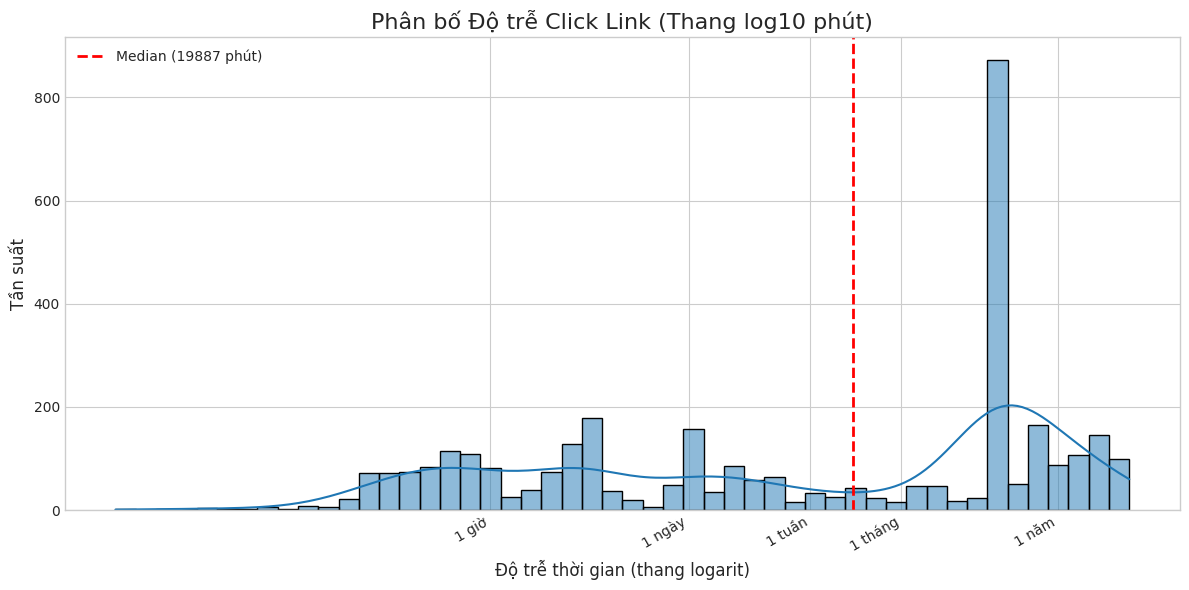

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. TÍNH TOÁN VÀ CHUYỂN ĐỔI ĐỘ TRỄ ---
# Lọc các bản ghi có đủ timestamp t và hc
time_diff_frame = frame[frame["t"].notna() & frame["hc"].notna()].copy()
time_diff_sec = time_diff_frame["t"] - time_diff_frame["hc"]

# Lọc ra các độ trễ hợp lệ (click sau khi tạo link) và chuyển sang phút
valid_delay = time_diff_sec[time_diff_sec >= 0] / 60
print(valid_delay.describe())

# Loại bỏ giá trị 0 hoặc âm trước khi lấy log, sau đó lấy Log10
valid_delay_positive = valid_delay[valid_delay > 0]
log10_delay = np.log10(valid_delay_positive)

# --- 2. TRỰC QUAN HÓA LOG-TRANSFORMED HISTOGRAM ---
plt.style.use('seaborn-v0_8-whitegrid')

# Thiết lập font tiếng Việt
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False  # tránh lỗi dấu trừ

plt.figure(figsize=(12, 6))
sns.histplot(log10_delay, bins=50, kde=True, color="#1f77b4")

# Các mốc thời gian quan trọng (phút)
minute_marks = np.array([60, 1440, 10080, 43200, 525600])
log_minute_marks = np.log10(minute_marks)
label_names = ["1 giờ", "1 ngày", "1 tuần", "1 tháng", "1 năm"]

plt.xticks(log_minute_marks, label_names, rotation=30, ha='right')

# Thêm đường tham chiếu cho Median (Q2)
median_delay = valid_delay.median()
if median_delay > 0:
    median_log_delay = np.log10(median_delay)
    plt.axvline(median_log_delay, color='red', linestyle='--', linewidth=2,
                label=f'Median ({median_delay:.0f} phút)')

plt.title('Phân bố Độ trễ Click Link (Thang log10 phút)', fontsize=16)
plt.xlabel('Độ trễ thời gian (thang logarit)', fontsize=12)
plt.ylabel('Tần suất', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


Tính Thời sự (Tập trung ban đầu): Biểu đồ cho thấy một đỉnh cao (mode) lớn ngay sau mốc 1 ngày và kéo dài đến 1 tuần. Điều này có nghĩa là phần lớn các hoạt động click có tính chất thời sự, xảy ra trong tuần đầu tiên sau khi link được tạo.

Giá trị Lưu trữ (Phần đuôi dài): Mặc dù tần suất giảm dần sau 1 tháng, biểu đồ vẫn có một "đuôi" kéo dài rõ rệt cho đến tận mốc 1 năm và thậm chí là 10 năm (phía bên phải). Điều này là bằng chứng mạnh mẽ rằng một lượng đáng kể người dùng vẫn tìm kiếm và click vào các liên kết rất cũ, khẳng định các tài liệu chính phủ có giá trị lưu trữ và tra cứu vĩnh viễn.

### 4.5. Địa lý: Những bang (gr) hoặc thành phố (cy) nào có lượng truy cập lớn nhất?


Mục tiêu: Xác định các điểm nóng truy cập địa phương và đánh giá sự phân phối lưu lượng truy cập cấp bang/thành phố.

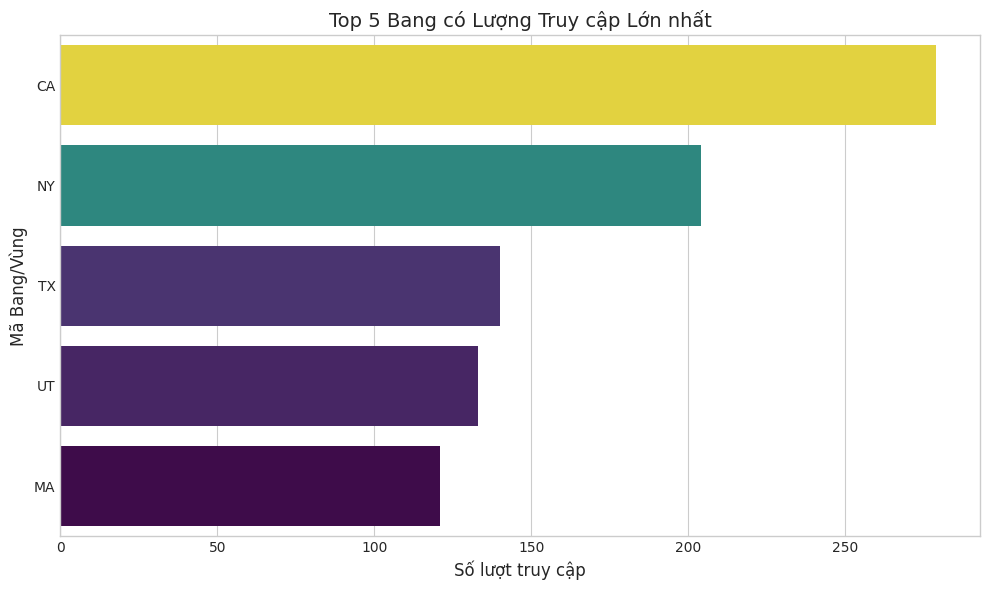

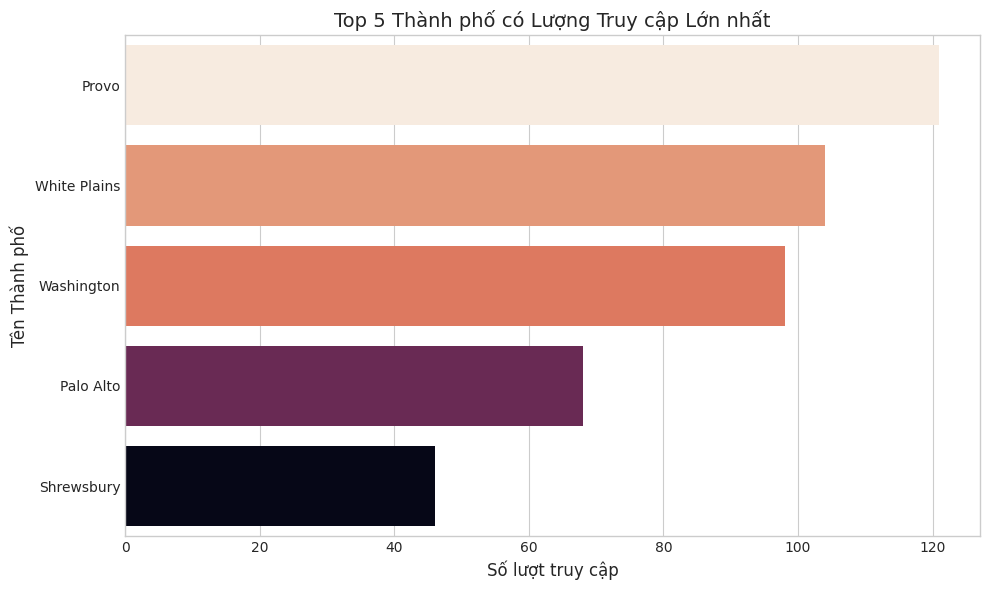

In [9]:
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial']
plt.rcParams['axes.unicode_minus'] = False

# Tính toán Top 5 Bang và Thành phố
# (Giả định DataFrame 'frame' đã được tải và làm sạch ở các bước trước)
top_states = frame["gr"].value_counts().head(5).dropna()
top_cities = frame["cy"].value_counts().head(5).dropna()

# Chuyển Series sang DataFrame cho Seaborn (chuẩn best practice)
gr_df = top_states.reset_index()
gr_df.columns = ['Bang', 'Số lượt truy cập']
cy_df = top_cities.reset_index()
cy_df.columns = ['Thành phố', 'Số lượt truy cập']

# --- 1. Biểu đồ Top 5 Bang (gr) ---
plt.figure(figsize=(10, 6))
sns.barplot(x='Số lượt truy cập', y='Bang', data=gr_df, palette='viridis', hue='Số lượt truy cập', legend=False)
plt.title('Top 5 Bang có Lượng Truy cập Lớn nhất', fontsize=14)
plt.xlabel('Số lượt truy cập', fontsize=12)
plt.ylabel('Mã Bang/Vùng', fontsize=12)
plt.tight_layout()
plt.savefig('plot_top_states.png')
plt.show()
plt.close()

# --- 2. Biểu đồ Top 5 Thành phố (cy) ---
plt.figure(figsize=(10, 6))
sns.barplot(x='Số lượt truy cập', y='Thành phố', data=cy_df, palette='rocket', hue='Số lượt truy cập', legend=False)
plt.title('Top 5 Thành phố có Lượng Truy cập Lớn nhất', fontsize=14)
plt.xlabel('Số lượt truy cập', fontsize=12)
plt.ylabel('Tên Thành phố', fontsize=12)
plt.tight_layout()
plt.savefig('plot_top_cities.png')
plt.show()
plt.close()

Các bang CA, NY, TX dẫn đầu, phù hợp với mật độ dân số. Sự xuất hiện đáng chú ý của các thành phố không phải là trung tâm hành chính lớn như Provo, UT và Shrewsbury, MA cho thấy các chiến dịch truyền thông cấp địa phương đã đạt được hiệu quả rõ rệt trong việc phân phối thông tin.

### 4.6. Địa lý: Người dùng từ ngoài nước Mỹ (c != 'US') chiếm bao nhiêu phần trăm?

Mục tiêu: Đánh giá phạm vi tiếp cận toàn cầu của thông tin Chính phủ Mỹ.

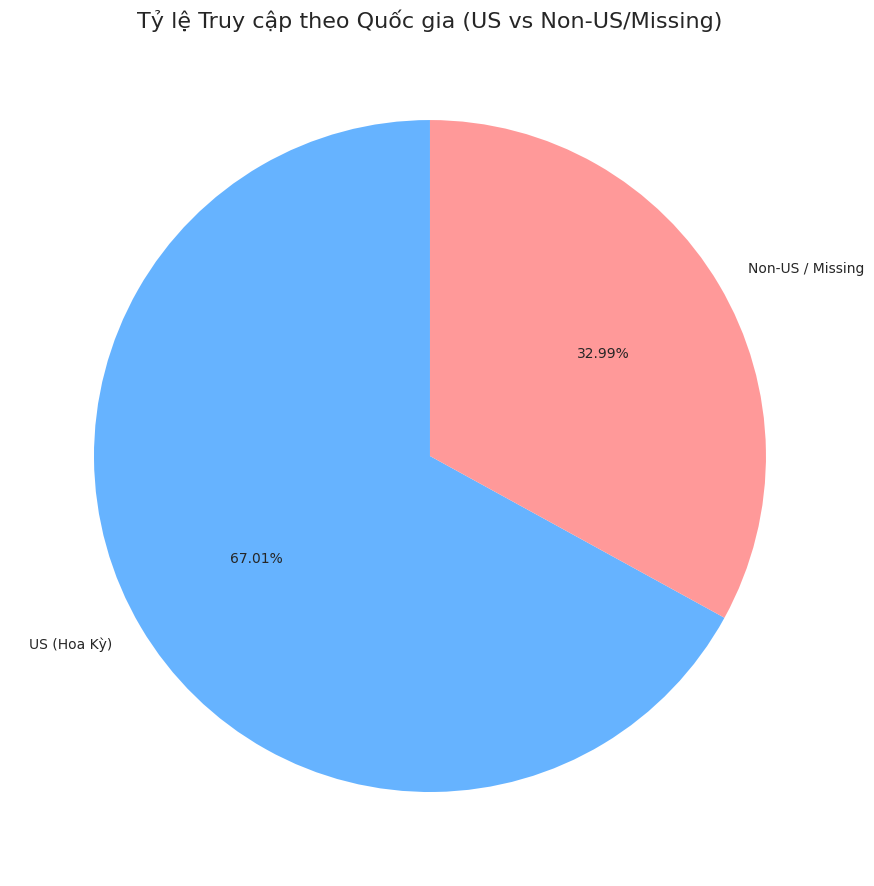

In [10]:
# --- Cấu hình font cho Matplotlib để hỗ trợ tiếng Việt ---
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial']
plt.rcParams['axes.unicode_minus'] = False

# Tính toán tỷ lệ US vs Non-US
total_records = len(frame)
clean_country = frame["c"].fillna("Missing")
non_us_count = (clean_country != "US").sum()
us_count = (clean_country == "US").sum()
country_data = pd.Series([us_count, non_us_count], index=['US (Hoa Kỳ)', 'Non-US / Missing'])

# --- Biểu đồ Pie Chart ---
plt.figure(figsize=(9, 9))
plt.pie(country_data,
        labels=country_data.index,
        autopct='%1.2f%%', # Định dạng hiển thị 2 số thập phân
        startangle=90,
        colors=['#66b3ff', '#ff9999'])
plt.title('Tỷ lệ Truy cập theo Quốc gia (US vs Non-US/Missing)', fontsize=16)
plt.tight_layout()
plt.savefig('plot_us_nonus_ratio.png')
plt.show()

Dữ liệu khẳng định sức ảnh hưởng của thông tin chính phủ là toàn cầu, với 32.99% lưu lượng truy cập đến từ ngoài nước Mỹ. Điều này nhấn mạnh sự cần thiết của việc duy trì nội dung rõ ràng, dễ tiếp cận và phù hợp với khán giả quốc tế.

### 4.7. Nguồn truy cập: Có sự khác biệt referrer theo hệ điều hành không?

Mục tiêu: Đánh giá sự khác biệt về thiết bị trên các nền tảng giới thiệu để tối ưu hóa nội dung.


--- Phân bố Referrer theo Hệ điều hành (Tỷ lệ %) ---
os                     Not Windows  Windows
r_source                                   
facebook.com                 27.74    72.26
google                       31.91    68.09
twitter.com                  50.28    49.72
www.AwareMap.com            100.00     0.00
www.shrewsbury-ma.gov        13.33    86.67


<Figure size 1200x700 with 0 Axes>

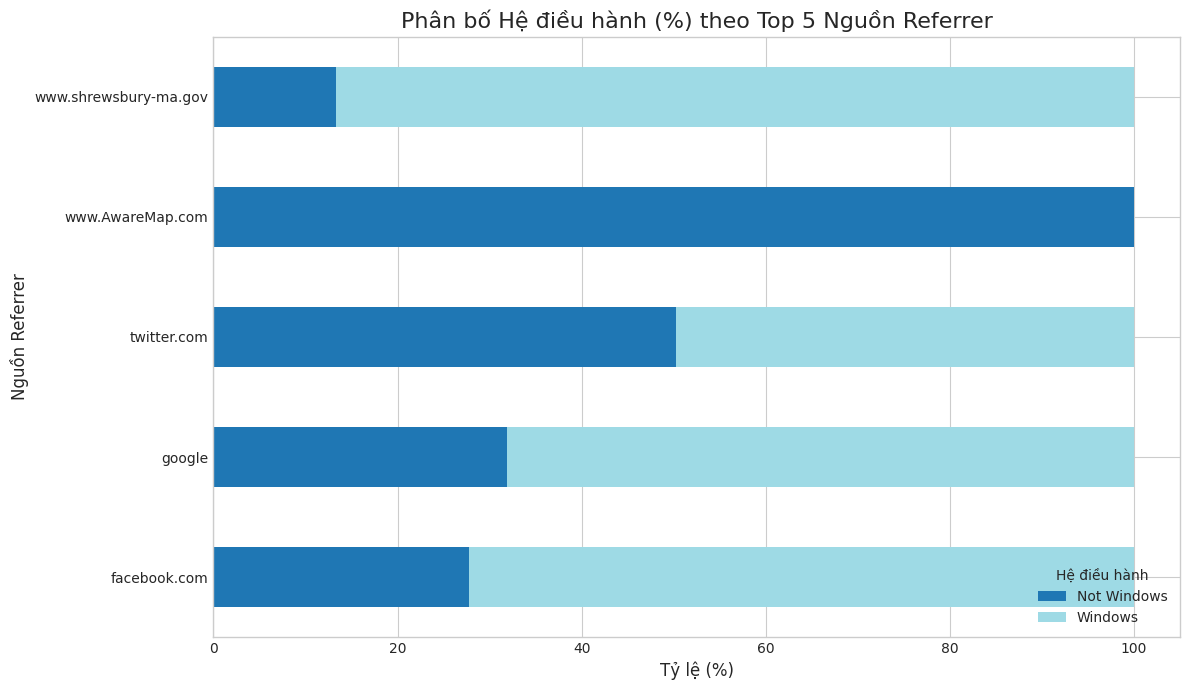

In [11]:
# Tính toán và in Phân bố Referrer theo Hệ điều hành
top_referrers_list = filtered_referrers.value_counts().head(5).index.tolist()
referrer_os_cframe = cframe[cframe["r"].notna()].copy()
referrer_os_cframe["r_source"] = referrer_os_cframe["r"].apply(get_referrer_source)
top_referrer_os_counts = referrer_os_cframe[
    referrer_os_cframe["r_source"].isin(top_referrers_list)
].groupby(["r_source", "os"]).size().unstack(fill_value=0)
referrer_os_percentage = top_referrer_os_counts.apply(lambda x: x / x.sum(), axis=1) * 100

print("\n--- Phân bố Referrer theo Hệ điều hành (Tỷ lệ %) ---")
print(referrer_os_percentage.round(2))

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(12, 7))
referrer_os_percentage.plot(kind='barh', stacked=True, figsize=(12, 7), colormap='tab20')

plt.title('Phân bố Hệ điều hành (%) theo Top 5 Nguồn Referrer', fontsize=16)
plt.xlabel('Tỷ lệ (%)', fontsize=12)
plt.ylabel('Nguồn Referrer', fontsize=12)
plt.legend(title='Hệ điều hành', loc='lower right')
plt.tight_layout()
plt.show()
plt.close()

Mối tương quan Referrer-OS cho thấy sự phân hóa thiết bị: Twitter thu hút người dùng cân bằng (50% Windows vs 50% Non-Windows), yêu cầu nội dung phải thân thiện với di động. Ngược lại, Facebook có xu hướng Windows cao hơn (72.26%). Phân tích này là chìa khóa chiến lược để tùy chỉnh nội dung: ví dụ, nên sử dụng các định dạng nhẹ và video ngắn cho Twitter và cân nhắc tài liệu nặng hơn cho Facebook.